<a href="https://colab.research.google.com/github/CwickHolmesalot/PowerDensity_AAPG2024/blob/main/AAPG05_DataEngineering_PowerPlantScale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rethinking Power Density for Geothermal Resource Estimation<br>
## Script 5: Data engineering for plant-scale predictive modeling<br>
Author: Chad Holmes<br>
Date: December 2024

### load libraries

In [ ]:
!pip install rasterio tqdm jenkspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.9/650.9 kB 33.1 MB/s eta 0:00:00


In [ ]:
# load libraries
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import pickle as pkl
import urllib.parse
import requests
import time
import gc
import jenkspy
import rasterio
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

### mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### load data

In [ ]:
path = r'drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG'
dirpath = Path(path)

In [ ]:
# define file locations
geofile = dirpath / 'Input' / 'PowerDensityPlot.xlsx'
kmlfile = dirpath / 'Input' / 'Geothermal Power Plants KML.xlsx'
dbfile  = dirpath / 'Input' / 'GPPD_geothermal.xlsx'
rysfile = dirpath / 'Input' / 'Ry_Tectonics_Matched.xlsx'
ecmfile = dirpath / 'Input' / 'ECM1.txt'
hffile  = dirpath / 'Input' / 'HFgrid14.csv'
gctfile = dirpath / 'Input' / 'ECM_Hcc_0p25deg_THG.csv'

# extract data from WorldClim
tminstem = 'wc2.1_30s_tmin'
tmaxstem = 'wc2.1_30s_tmax'
tavgstem = 'wc2.1_30s_tavg'
precstem = 'wc2.1_30s_prec'

In [ ]:
# load data
pd_orig  = pd.read_excel(geofile)
kml_orig = pd.read_excel(kmlfile)
gdf_orig = pd.read_excel(dbfile)
rys_orig = pd.read_excel(rysfile)
ecm_orig = pd.read_csv(ecmfile,delimiter='\t')
hf_orig = pd.read_csv(hffile,delimiter=';')
gct_orig = pd.read_csv(gctfile,sep='\s+')

pd_orig.head()

,Name,WS_Temp,WS_PowerDensity,WS_TectonicRegime
0,Oguni,225.0,0.864198,Arcs
1,Suginoi,210.0,1.234568,Arcs
2,Mataloko,240.0,2.345679,Arcs
3,Hachijojima,300.0,2.469136,Arcs
4,Sibayak,280.0,2.530864,Arcs


### First-pass Filtering and Data Cleaning

In [ ]:
# filter out unlabeled power plants from Wilmarth et al's plot
pd_orig = pd_orig[pd_orig.Name != 'Unknown']
pd_orig.shape

(100, 4)

In [ ]:
# print(rys_orig.loc[:,'Subsurface system'].unique())
rys_orig = rys_orig[rys_orig.MatchName.isna() == False]

# restrict to power-generating hydrothermal systems
rys_conv = rys_orig[rys_orig['Asset purpose']      == 'Power generation']
rys_conv = rys_conv[(rys_orig['Subsurface system'] == 'Hydrothermal')]

In [ ]:
rys_conv['Subsurface system'].value_counts()

,count
Subsurface system,
Hydrothermal,410


In [ ]:
# select fields of interest from Rystad data
keepcols = ['Country', 'Asset', 'MatchName', 'RystadLatitude', 'RystadLongitude', #'Subsurface system',
            'Technology', 'Temperature', 'Reservoir temperature (°C)', 'Startup year',
            'Installed capacity (MWe)', 'Production wells', 'Total wells',
            'Drilling length group (meters)', 'MW per well', 'PowerPerWell']

# sort conventional geothermal plants by start year
rys_conv = rys_conv.sort_values(by='Startup year', ascending=True)

# update data types
rys_conv['Production wells'] = rys_conv['Production wells'].astype(int)
rys_conv['Total wells']      = rys_conv['Total wells'].astype(int)
rys_conv['Startup year']     = rys_conv['Startup year'].astype(float)
rys_conv['Reservoir temperature (°C)'] = rys_conv['Reservoir temperature (°C)'].astype(float)
rys_conv['Installed capacity (MWe)']   = rys_conv['Installed capacity (MWe)'].astype(float)
rys_conv['MW per well']      = rys_conv['MW per well'].astype(float)

In [ ]:
# Calculate average power produced per production well based on installed capacity (net capacity is underdefined)
rys_conv['PowerPerWell'] = [a/b for a,b in zip(rys_conv['Installed capacity (MWe)'],rys_conv['Production wells'])]

In [ ]:
# calculates the mode of a categorical data feature
def determine_categorical_mode(a):
    cnts = a.value_counts()
    return cnts.index[cnts.argmax()]

In [ ]:
# Define the order of the categories
temp_order = ['<50 °C','50-100 °C','100-150 °C','150-200 °C','200-250 °C','250+ °C']

# Convert the column to an ordered categorical variable
rys_conv['Temperature'] = rys_conv['Temperature'].astype(CategoricalDtype(categories=temp_order, ordered=True))

rys_conv['Drilling length group (meters)'] = rys_conv['Drilling length group (meters)'].replace({'0-500 meters':'a. 0-500 meters',
                                                                      '500-1,000 meters':'b. 500-1,000 meters',
                                                                      '1,000-1,500 meters':'c. 1,000-1,500 meters',
                                                                      '1,500-2,000 meters':'d. 1,500-2,000 meters',
                                                                      '2,000-2,500 meters':'e. 2,000-2,500 meters',
                                                                      '2,500-3,000 meters':'f. 2,500-3,000 meters',
                                                                      '3,000-3,500 meters':'g. 3,000-3,500 meters',
                                                                      '3,500-4,000 meters':'h. 3,500-4,000 meters',
                                                                      '4,000-4,500 meters':'i. 4,000-4,500 meters',
                                                                      '4,500-5,000 meters':'j. 4,500-5,000 meters',
                                                                      '5,000-5,500 meters':'k. 5,000-5,500 meters',
                                                                      '5,500-6,000 meters':'l. 5,500-6,000 meters',
                                                                      '6,000+ meters':     'm. 6,000-6,500 meters'})

# Define the order of the categories
depth_order = ['a. 0-500 meters',      'b. 500-1,000 meters',
               'c. 1,000-1,500 meters','d. 1,500-2,000 meters',
               'e. 2,000-2,500 meters','f. 2,500-3,000 meters',
               'g. 3,000-3,500 meters','h. 3,500-4,000 meters',
               'i. 4,000-4,500 meters','j. 4,500-5,000 meters',
               'k. 5,000-5,500 meters','l. 5,500-6,000 meters',
               'm. 6,000-6,500 meters']

# Convert the column to an ordered categorical variable
rys_conv['Drilling length group (meters)'] = rys_conv['Drilling length group (meters)'].astype(CategoricalDtype(categories=depth_order, ordered=True))

# Display the resulting DataFrame
# print(rys_conv['Drilling length group (meters)'])

In [ ]:
rys_conv.Technology.value_counts()

,count
Technology,
Flash,217
Binary,106
Dry steam,78
Hybrid,6
Flash and binary,3


In [ ]:
# NO AGGREGATION OF POWER PLANTS!

# # mass aggregation of Rystad data set to match Wilmarth et al. plot
# keepcols = [c for c in keepcols if c != 'Technology']
# rys_agg = rys_conv[keepcols].groupby(['MatchName']).aggregate({'Country':'first',
#                                                                'Asset':'first',
#                                                                'RystadLatitude':'mean',
#                                                                'RystadLongitude':'mean',
#                                                                'Temperature':determine_categorical_mode,
#                                                                'Reservoir temperature (°C)':'mean',
#                                                                'Startup year':'min',
#                                                                'Installed capacity (MWe)':'sum',
#                                                                'Production wells':'sum',
#                                                                'Total wells':'sum',
#                                                                'Drilling length group (meters)':determine_categorical_mode,
#                                                                'MW per well':'mean',
#                                                                'PowerPerWell':'mean'}).reset_index(drop=False)
rys_agg = rys_conv.reset_index(drop=True)

In [ ]:
# quickly screen out power plants that are new or planned
rys_agg = rys_agg[rys_agg['Startup year'] <= 2022]
rys_agg.shape

(388, 20)

### Get elevations from OpenTopoData

In [ ]:
def get_all_elevations(lat, lon):
    locs = [f"{l1},{l2}" for l1,l2 in zip(lat,lon)]
    locstr = '|'.join(locs)
    print(locstr)
    base_url = "https://api.opentopodata.org/v1/etopo1?"
    params = {
        "locations": locstr,
        "nodata_value": -9999
    }
    response = requests.get(base_url + urllib.parse.urlencode(params))
    print(response)
    data = response.json()
    print(data)
    time.sleep(1)
    return data['results'][0]['elevation']

def get_elevation(lat, lon):
    base_url = "https://api.opentopodata.org/v1/etopo1?"
    params = {
        "locations": f"{lat},{lon}",
        "nodata_value": -9999
    }
    response = requests.get(base_url + urllib.parse.urlencode(params))
    data = response.json()
    print(data)
    time.sleep(1)
    return data['results'][0]['elevation']

In [ ]:
# extract elevations
kml_topo = kml_orig[kml_orig.InWSPlot==True]
kml_topo.loc[:,'Elevation'] = [get_elevation(lat,lon) for lat,lon in zip(kml_topo.Latitude, kml_topo.Longitude)]

# aggregate locations and topography
kml_topo = kml_topo.groupby('MatchName').aggregate({'Country':'first','PowerPlant':'first','Latitude':'mean','Longitude':'mean','Elevation':'mean'})
kml_topo.head(50)

{'results': [{'dataset': 'etopo1', 'elevation': 798.0, 'location': {'lat': 13.9201595259298, 'lng': -89.8171761325335}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 1223.0, 'location': {'lat': 40.3009100227308, 'lng': -120.194903434064}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 159.0, 'location': {'lat': 37.80135537016, 'lng': -25.5053947446847}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 629.0, 'location': {'lat': 13.0547190321669, 'lng': 123.967560025956}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 564.0, 'location': {'lat': 13.0599306181687, 'lng': 123.929582995473}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 745.0, 'location': {'lat': 13.0348575260683, 'lng': 123.93730936974}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 1511.0, 'location': {'lat': 40.5548292885136, 'lng': -116.617000480228}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'el

<ipython-input-18-d9402b91e90f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kml_topo.loc[:,'Elevation'] = [get_elevation(lat,lon) for lat,lon in zip(kml_topo.Latitude, kml_topo.Longitude)]


,Country,PowerPlant,Latitude,Longitude,Elevation
MatchName,,,,,
Ahuachapan,Central_America,Ahuachapan,13.920160,-89.817176,798.000000
Amedee,US-Canada,Amedee,40.300910,-120.194903,1223.000000
Azores,Iceland-Hawaii-Azores,Pico Vermelho,37.801355,-25.505395,159.000000
BacMan,Philippines,Bacman a,13.049836,123.944817,646.000000
Beowawe,US-Canada,Beowawe,40.554829,-116.617000,1511.000000
Blue Mountain,US-Canada,Blue Mtn,40.995143,-118.142756,1300.000000
Blundell,US-Canada,Roosevelt,38.488826,-112.853004,1852.000000
Bouillante,Caribbean,La Bouillante,16.127205,-61.769062,82.000000
Bradys,US-Canada,Bradys flash,39.795915,-119.009404,1273.000000


### First merge

In [ ]:
# merge original power density data with lat/long info from kml file
combodf = pd.merge(left=pd_orig, right=kml_topo, how='left',left_on='Name',right_on='MatchName')
combodf = combodf.drop([c for c in combodf.columns if 'xx_' in c],axis=1)

# save out results as intermediate output
combodf.to_excel(dirpath / 'Output' / 'pd_kml_combo_PLANTS.xlsx')

print(combodf.shape)
combodf.head(10)

(100, 9)


,Name,WS_Temp,WS_PowerDensity,WS_TectonicRegime,Country,PowerPlant,Latitude,Longitude,Elevation
0,Oguni,225.0,0.864198,Arcs,Japan,Oguni,33.138653,131.147106,973.0
1,Suginoi,210.0,1.234568,Arcs,Japan,Suginoi Hotel,33.281659,131.468192,320.5
2,Mataloko,240.0,2.345679,Arcs,Indonesia_PapuaNG,Mataloko,-8.833641,121.060828,1038.0
3,Hachijojima,300.0,2.469136,Arcs,Japan,Hachijojima,33.074797,139.812391,256.0
4,Sibayak,280.0,2.530864,Arcs,Indonesia_PapuaNG,Sibayak,3.227134,98.513641,1604.0
5,Onikobe,235.0,3.148148,Arcs,Japan,Onikobe,38.809768,140.708730,598.0
6,Onuma,225.0,3.641975,Arcs,Japan,Ohnuma,39.985779,140.805054,963.0
7,Karaha-Telaga Bodas,290.0,5.802469,Arcs,Indonesia_PapuaNG,Karaha-Telaga Bodas,-7.180120,108.074199,1440.0
8,Uenotai,310.0,5.802469,Arcs,Japan,Uenotai,39.001512,140.603915,681.0
9,Yamakawa,305.0,6.111111,Arcs,Japan,Yamakawa,31.190653,130.614479,24.0


### Second merge

In [ ]:
# remove extra columns from GPPDB
keep_cols = ['country','country_long','MatchName','Name','capacity_mw','latitude','longitude','commissioning_year','owner','estimated_generation_gwh_2017']
gdf_edit = gdf_orig[gdf_orig.InPowerDensityPlot==True][keep_cols]

# clear out whitespace from MatchName
gdf_edit.loc[:,'MatchName'] = gdf_edit.MatchName.apply(str.strip)

# rename columns
new_col_names = ['CountryShort','CountryLong','MatchName','GPPDBName','NameplateCapacity','GPPDBLatitude','GPPDBLongitude','FirstCommissionYear','Owner','EstGenerationPerYear']
gdf_edit.columns = new_col_names

# sort on commissioning year
gdf_edit.sort_values(by='FirstCommissionYear',inplace=True)

print(gdf_edit.shape)
gdf_edit.head()

(153, 10)


,CountryShort,CountryLong,MatchName,GPPDBName,NameplateCapacity,GPPDBLatitude,GPPDBLongitude,FirstCommissionYear,Owner,EstGenerationPerYear
107,NZL,New Zealand,Wairakei-Tauhara,Wairakei,132.0,-38.6266,176.1055,1958.0,Contact Energy,985.76
72,JPN,Japan,Matsukawa,Matsukawa Geothermal,23.5,39.9271,140.9333,1966.0,TOHOKU ELECTRIC POWER CO,105.85
77,JPN,Japan,Otake,Otake,12.5,33.1217,131.1902,1967.0,KYUSHU ELECTRIC POWER CO,56.30
76,JPN,Japan,Onuma,Onuma Plant,9.5,39.9813,140.7819,1973.0,HOKKAIDO ELECTRIC POWER CO INC,42.79
91,MEX,Mexico,Cerro Prieto,Cerro Prieto,820.0,32.3916,-115.2252,1973.0,CFE,5396.00


In [ ]:
# aggregate on MatchName
gdf = gdf_edit.groupby("MatchName").aggregate({'CountryShort':'first',
                                               'CountryLong':'first',
                                               'GPPDBName':'first',
                                               'NameplateCapacity':'sum',
                                               'GPPDBLatitude':'mean',
                                               'GPPDBLongitude':'mean',
                                               'FirstCommissionYear':'min',
                                               'Owner':'first',
                                               'EstGenerationPerYear':'sum'}).reset_index(drop=False)
combodf2 = pd.merge(left=combodf, right=gdf, how='outer',left_on='Name',right_on='MatchName')

# save out results as intermediate output
combodf2.to_excel(dirpath / 'Output' / 'pd_kml_gppdb_combo_PLANTS.xlsx')
combodf2.shape

(100, 19)

### Third merge

In [ ]:
# aggregate on MatchName
combodf3 = pd.merge(left=combodf2, right=rys_agg, how='outer',left_on='Name',right_on='MatchName')
combodf3.to_excel(dirpath / 'Output' / 'pd_kml_gppdb_rys_combo_PLANTS.xlsx')
combodf3.shape

(388, 39)

In [ ]:
# check that number of field names is consistent
print(len(combodf3.MatchName_x.unique()),len(combodf3.MatchName_y.unique()))

100 100


### filter the data based on start/commission year

In [ ]:
# combine various year columns into one "truth"
combodf3['FirstCommissionYear'] = combodf3['FirstCommissionYear'].fillna(9999)
combodf3['Startup year'] = combodf3['Startup year'].fillna(9999)
combodf3['EstFirstYear'] = [min(int(y1),int(y2)) for y1,y2 in zip(combodf3['FirstCommissionYear'],combodf3['Startup year'])]

# focus on plants commissioned no later than 2022
gdf = combodf3[combodf3['EstFirstYear'] <= 2022]

# check that we still have the same number of unique fields
print(gdf.shape, gdf.Name.nunique())

(388, 40) 100


In [ ]:
gdf.columns

Index(['Name', 'WS_Temp', 'WS_PowerDensity', 'WS_TectonicRegime', 'Country_x',
       'PowerPlant', 'Latitude', 'Longitude', 'Elevation', 'MatchName_x',
       'CountryShort', 'CountryLong', 'GPPDBName', 'NameplateCapacity',
       'GPPDBLatitude', 'GPPDBLongitude', 'FirstCommissionYear', 'Owner',
       'EstGenerationPerYear', 'Country_y', 'State', 'Project', 'Asset',
       'TectonicRegime', 'MatchName_y', 'RystadLatitude', 'RystadLongitude',
       'Asset purpose', 'Technology', 'Subsurface system', 'Temperature',
       'Reservoir temperature (°C)', 'Startup year',
       'Installed capacity (MWe)', 'Production wells', 'Total wells',
       'Drilling length group (meters)', 'MW per well', 'PowerPerWell',
       'EstFirstYear'],
      dtype='object')

### Grab climate values from geotiffs

In [ ]:
def get_clim_value(stem,latlondf):

    values = np.zeros(latlondf.shape[0])

    # build path
    tifpath = dirpath / 'Input' / (stem + '_summary.tif')
    print(f'opening tif file: {tifpath}')

    # open the climate normals data set
    with rasterio.open(tifpath) as src:

        # for each location in the input dataframe
        for k in range(latlondf.shape[0]):

            lat,lon = latlondf.iloc[k,0],latlondf.iloc[k,1]

            # Use the `index` function to find the indices of the given latitude and longitude
            row, col = src.index(lon,lat)

            # Use these indices to read the corresponding pixel value from the dataset
            v = src.read(1)[row, col]
            print(k,lat,lon,v)
            values[k] = v

    return values

In [ ]:
# average temperature
gdf.loc[:,'WorldClim_AvgTemp'] = get_clim_value(tavgstem,gdf[['Latitude','Longitude']])

opening tif file: drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG/Input/wc2.1_30s_tavg_summary.tif
0 13.9201595259298 -89.8171761325335 23.074999
1 13.9201595259298 -89.8171761325335 23.074999
2 13.9201595259298 -89.8171761325335 23.074999
3 40.3009100227308 -120.194903434064 9.983333
4 37.80135537016 -25.5053947446847 17.066668
5 37.80135537016 -25.5053947446847 17.066668
6 37.80135537016 -25.5053947446847 17.066668
7 37.80135537016 -25.5053947446847 17.066668
8 37.80135537016 -25.5053947446847 17.066668
9 13.049835725467966 123.944817463723 23.491667
10 13.049835725467966 123.944817463723 23.491667
11 13.049835725467966 123.944817463723 23.491667
12 40.5548292885136 -116.617000480228 9.591666
13 40.5548292885136 -116.617000480228 9.591666
14 40.9951430092967 -118.142755594725 10.466666
15 38.4888256468502 -112.853003951582 9.391666
16 38.4888256468502 -112.853003951582 9.391666
17 16.1272054141903 -61.7690616794216 -999.0
18 16.1272054141903 -61.7690616794216 -999.0
19 39.7959

In [ ]:
# min temperature
gdf.loc[:,'WorldClim_MinTemp'] = get_clim_value(tminstem,gdf[['RystadLatitude','RystadLongitude']])

opening tif file: drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG/Input/wc2.1_30s_tmin_summary.tif
0 13.9204 -89.8174 15.7
1 13.9205 -89.8173 15.7
2 13.9206 -89.8172 15.7
3 40.3008 -120.195 -6.2
4 37.8015 -25.5056 11.2
5 37.77907 -25.4901 9.7
6 37.77917 -25.49 9.7
7 37.8016 -25.5055 11.2
8 37.77927 -25.4899 9.7
9 13.06031 123.9291 19.6
10 13.05477 123.9677 19.4
11 13.03478 123.9373 18.4
12 40.5547 -116.617 -8.2
13 40.5546 -116.623 -8.2
14 40.9951 -118.143 -7.5
15 38.489 -112.854 -9.2
16 38.4887 -112.852 -9.2
17 16.12744 -61.7689 -3.4e+38
18 16.12754 -61.7688 -3.4e+38
19 39.796 -119.009 -6.2
20 39.7965 -119.01 -6.2
21 39.79603 -119.01 -6.2
22 32.41245 -115.2444 7.0
23 32.41255 -115.2443 7.0
24 32.41265 -115.2442 7.0
25 32.41275 -115.2441 7.0
26 32.39191 -115.2254 7.0
27 32.39201 -115.2253 7.0
28 32.39881 -115.2386 7.0
29 32.39891 -115.2385 7.0
30 32.41285 -115.244 7.0
31 32.4052 -115.2117 6.8
32 32.4051 -115.2118 6.8
33 32.405 -115.2119 6.8
34 32.4049 -115.212 6.8
35 65.0527 -146

In [ ]:
# max temperature
gdf.loc[:,'WorldClim_MaxTemp'] = get_clim_value(tmaxstem,gdf[['RystadLatitude','RystadLongitude']])

opening tif file: drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG/Input/wc2.1_30s_tmax_summary.tif
0 13.9204 -89.8174 30.3
1 13.9205 -89.8173 30.3
2 13.9206 -89.8172 30.3
3 40.3008 -120.195 32.5
4 37.8015 -25.5056 25.0
5 37.77907 -25.4901 23.2
6 37.77917 -25.49 23.2
7 37.8016 -25.5055 25.0
8 37.77927 -25.4899 23.2
9 13.06031 123.9291 29.5
10 13.05477 123.9677 29.1
11 13.03478 123.9373 28.2
12 40.5547 -116.617 33.4
13 40.5546 -116.623 33.4
14 40.9951 -118.143 33.8
15 38.489 -112.854 32.5
16 38.4887 -112.852 32.5
17 16.12744 -61.7689 -3.4e+38
18 16.12754 -61.7688 -3.4e+38
19 39.796 -119.009 34.6
20 39.7965 -119.01 34.6
21 39.79603 -119.01 34.6
22 32.41245 -115.2444 38.9
23 32.41255 -115.2443 38.9
24 32.41265 -115.2442 38.9
25 32.41275 -115.2441 38.9
26 32.39191 -115.2254 39.1
27 32.39201 -115.2253 39.1
28 32.39881 -115.2386 39.0
29 32.39891 -115.2385 39.0
30 32.41285 -115.244 38.9
31 32.4052 -115.2117 39.4
32 32.4051 -115.2118 39.4
33 32.405 -115.2119 39.4
34 32.4049 -115.212 39.4

In [ ]:
# average precipitation
gdf.loc[:,'WorldClim_AvgPrec'] = get_clim_value(precstem,gdf[['RystadLatitude','RystadLongitude']])

opening tif file: drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG/Input/wc2.1_30s_prec_summary.tif
0 13.9204 -89.8174 144
1 13.9205 -89.8173 144
2 13.9206 -89.8172 144
3 40.3008 -120.195 26
4 37.8015 -25.5056 82
5 37.77907 -25.4901 96
6 37.77917 -25.49 96
7 37.8016 -25.5055 82
8 37.77927 -25.4899 96
9 13.06031 123.9291 278
10 13.05477 123.9677 281
11 13.03478 123.9373 276
12 40.5547 -116.617 19
13 40.5546 -116.623 19
14 40.9951 -118.143 17
15 38.489 -112.854 24
16 38.4887 -112.852 24
17 16.12744 -61.7689 0
18 16.12754 -61.7688 0
19 39.796 -119.009 12
20 39.7965 -119.01 12
21 39.79603 -119.01 12
22 32.41245 -115.2444 4
23 32.41255 -115.2443 4
24 32.41265 -115.2442 4
25 32.41275 -115.2441 4
26 32.39191 -115.2254 4
27 32.39201 -115.2253 4
28 32.39881 -115.2386 4
29 32.39891 -115.2385 4
30 32.41285 -115.244 4
31 32.4052 -115.2117 4
32 32.4051 -115.2118 4
33 32.405 -115.2119 4
34 32.4049 -115.212 4
35 65.0527 -146.057 23
36 64.80165 -147.935 25
37 36.0375 -117.798 15
38 36.0067 -117.

In [ ]:
gdf.columns

Index(['Name', 'WS_Temp', 'WS_PowerDensity', 'WS_TectonicRegime', 'Country_x',
       'PowerPlant', 'Latitude', 'Longitude', 'Elevation', 'MatchName_x',
       'CountryShort', 'CountryLong', 'GPPDBName', 'NameplateCapacity',
       'GPPDBLatitude', 'GPPDBLongitude', 'FirstCommissionYear', 'Owner',
       'EstGenerationPerYear', 'Country_y', 'State', 'Project', 'Asset',
       'TectonicRegime', 'MatchName_y', 'RystadLatitude', 'RystadLongitude',
       'Asset purpose', 'Technology', 'Subsurface system', 'Temperature',
       'Reservoir temperature (°C)', 'Startup year',
       'Installed capacity (MWe)', 'Production wells', 'Total wells',
       'Drilling length group (meters)', 'MW per well', 'PowerPerWell',
       'EstFirstYear', 'WorldClim_AvgTemp', 'WorldClim_MinTemp',
       'WorldClim_MaxTemp', 'WorldClim_AvgPrec'],
      dtype='object')

In [ ]:
# search for bad values
gdf[gdf.WorldClim_AvgTemp == -999].loc[:,['Name','CountryLong','Asset']]

,Name,CountryLong,Asset
17,Bouillante,Guadeloupe,"La Bouillante 1, GP"
18,Bouillante,Guadeloupe,"La Bouillante 2, GP"
132,Lihir,Papua New Guinea,"Lihir 1, PG"
133,Lihir,Papua New Guinea,"Lihir 2, PG"
134,Lihir,Papua New Guinea,"Lihir 3, PG"
251,Reykjanes,Iceland,"Reykjanes 1, IS"
252,Reykjanes,Iceland,"Reykjanes 2, IS"


In [ ]:
# fill in values for locations that failed during look0-ups
gdf = gdf.reset_index().set_index('Name')

# Lihir
gdf.loc['Lihir','Elevation'] = 5
gdf.loc['Lihir','WorldClim_AvgTemp'] = 27.5
gdf.loc['Lihir','WorldClim_MinTemp'] = 24.4
gdf.loc['Lihir','WorldClim_MaxTemp'] = 31.7
gdf.loc['Lihir','WorldClim_AvgPrec'] = 215.6

# Bouillante
gdf.loc['Bouillante','Elevation'] = 10.4
gdf.loc['Bouillante','WorldClim_AvgTemp'] = 28.2
gdf.loc['Bouillante','WorldClim_MinTemp'] = 18.6
gdf.loc['Bouillante','WorldClim_MaxTemp'] = 30.3
gdf.loc['Bouillante','WorldClim_AvgPrec'] = 78.6

# Reykjanes
gdf.loc['Reykjanes','Elevation'] = 27.4
gdf.loc['Reykjanes','WorldClim_AvgTemp'] = 5.2
gdf.loc['Reykjanes','WorldClim_MinTemp'] = -2.2
gdf.loc['Reykjanes','WorldClim_MaxTemp'] = 13.9
gdf.loc['Reykjanes','WorldClim_AvgPrec'] = 24.5

# range in temperature
gdf.loc[:,'WorldClim_TempRange'] = [mx-mn for mx,mn in zip(gdf.WorldClim_MaxTemp,gdf.WorldClim_MinTemp)]

In [ ]:
gdf.shape

(388, 45)

In [ ]:
# make sure index is reset
gdf = gdf.drop('index',axis=1).reset_index(drop=False)

In [ ]:
# search for bad values
gdf[gdf.WorldClim_AvgTemp == -999].loc[:,['Name','CountryLong','Asset']]

,Name,CountryLong,Asset


### some final data engineering

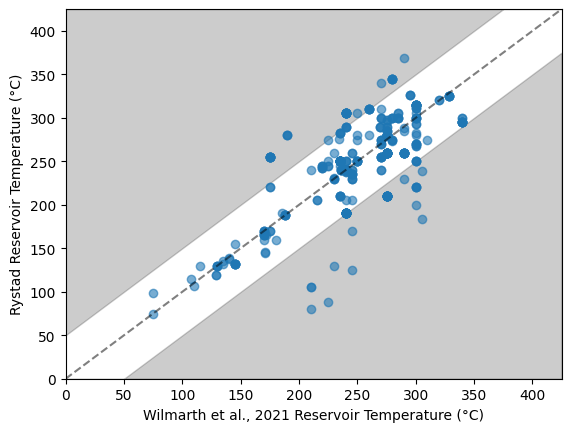

In [ ]:
# check reservoir temperature values
# comparison of Wilmarth et al. temps with temp data from Rystad

xlim = [0,425]
ylim = xlim
x = np.arange(xlim[0],xlim[1],0.1)
plt.plot(x, x,
         c='black',
         linestyle='dashed',
         alpha = 0.5)

# Fill the area where values differ by no more than 50 degrees C with white
plt.fill_between(x, x-50, x+50, color='white', alpha=0.1)

# Fill the areas above and below this central zone with gray
plt.fill_between(x, ylim[0], x-50, color='black', alpha=0.2)
plt.fill_between(x, x+50, ylim[1], color='black', alpha=0.2)

plt.scatter(gdf['WS_Temp'],
            gdf['Reservoir temperature (°C)'],
            alpha=0.6)
plt.xlim(xlim)
plt.ylim(ylim)

# plt.title('Reservoir Temperature from Different Sources')
plt.xlabel('Wilmarth et al., 2021 Reservoir Temperature (°C)')
plt.ylabel('Rystad Reservoir Temperature (°C)')


outfile = str('FigA1-Temperature_O2O.png')
plt.savefig(dirpath / 'Figures' / outfile, dpi=400)

plt.show()

In [ ]:
# identify fields that show temperature difference of 50 degrees or more
rtdiff = gdf
rtdiff.loc[:,'Temp Difference'] = [abs(w-r) for w,r in zip(gdf.WS_Temp,gdf['Reservoir temperature (°C)'])]
print(rtdiff[rtdiff['Temp Difference'] >=50].Name.unique())

# save off list to include in paper
rtdiff = rtdiff[rtdiff['Temp Difference'] >=50].loc[:,['Name','WS_Temp','Reservoir temperature (°C)','Temp Difference']]
rtdiff.to_excel(dirpath / 'Output' / 'rtdiff_PLANTS.xlsx')

['Blundell' 'Dieng' 'Dixie Valley' 'Krafla' 'Lahendong' 'Matsukawa'
 'Oguni' 'Olkaria' 'Onuma' 'Palinpinon' 'Pauzhetskaya' 'Salak West'
 'Suginoi' 'Takigami' 'The Geysers' 'Travale' 'Wairakei-Tauhara'
 'Yamakawa' 'Yangbajing']


In [ ]:
# start with WS_Temp values
gdf['PDTemp_Edited'] = gdf['WS_Temp']
gdf = gdf.drop(['Temp Difference'],axis=1)

# replace with updated values based on literature
gdf = gdf.set_index('Name')
gdf.loc['Blundell','PDTemp_Edited']         = 245 # Allis and Larsen, 2012
gdf.loc['Dieng','PDTemp_Edited']            = 300 # Shalihin et al., 2002
gdf.loc['Dixie Valley','PDTemp_Edited']     = 245 # Bergfeld, 2001
gdf.loc['Krafla','PDTemp_Edited']           = 300 # secondary zone (below 1400m), Ntihabose, 2014
gdf.loc['Lahendong','PDTemp_Edited']        = 300 # Utami et al., 2004
gdf.loc['Matsukawa','PDTemp_Edited']        = 250 # Hanano, 1994
gdf.loc['Oguni','PDTemp_Edited']            = 230 # Nakanishi et al., 1995
gdf.loc['Olkaria','PDTemp_Edited']          = 275 # Ofwona et al, 2000
gdf.loc['Onuma','PDTemp_Edited']            = 230 # Ariki and Kawakami, 2000
gdf.loc['Palinpinon','PDTemp_Edited']       = 300 # D'Amore et al., 1993
gdf.loc['Pauzhetskaya','PDTemp_Edited']     = 190 # Kiryukhin et al., 2006
gdf.loc['Salak West','PDTemp_Edited']       = 280 # (240-316) Peter, 2015
gdf.loc['Suginoi','PDTemp_Edited']          = 210 # Kudo et al, 1996, Hirakawa, 1983
gdf.loc['Takigami','PDTemp_Edited']         = 240 # Furuya, 1988
gdf.loc['The Geysers','PDTemp_Edited']      = 235 # Peacock, 2019
gdf.loc['Travale','PDTemp_Edited']          = 325 # (300-350) Bertani et al., 2005
gdf.loc['Wairakei-Tauhara','PDTemp_Edited'] = 255 # balance of Wairakei (below 255) and Tauhara (max 275) McDowell, 2020; Ciraiaco, 2020
gdf.loc['Yamakawa','PDTemp_Edited']         = 300 # Akaku et al., 1991
gdf.loc['Yangbajing','PDTemp_Edited']       = 250 # deeper reservoir, Ji and Ping, 2000
gdf = gdf.reset_index(drop=False)

In [ ]:
# simplify power plant categories
gdf.loc[:,'Technology'] = [t if t != 'Flash and binary' else 'Hybrid' for t in gdf['Technology']]

# update Puna based on research
gdf = gdf.set_index('Name')
gdf.loc['Puna','Technology'] = 'Hybrid'
gdf = gdf.reset_index(drop=False)

In [ ]:
# check for missing country labels
gdf.CountryLong.value_counts(dropna=False)

,count
CountryLong,
United States of America,72
Italy,46
Indonesia,41
Mexico,40
New Zealand,35
Iceland,28
Philippines,27
Japan,23
Kenya,16


In [ ]:
# add geographic region
ctry2region = {'Argentina':'South America',
               'Australia':'Oceania',
               'Austria':'Europe',
               'Bolivia':'South America',
               'Canada':'North America',
               'Chile':'South America',
               'China':'East Asia',
               'Colombia':'South America',
               'Costa Rica':'Central America',
               'Croatia':'Europe',
               'Democratic Republic of Congo':'Africa',
               'Djibouti':'Africa',
               'Dominica':'North America',
               'Ecuador':'South America',
               'El Salvador':'Central America',
               'Ethiopia':'Africa',
               'Finland':'Europe',
               'France':'Europe',
               'Germany':'Europe',
               'Greece':'Europe',
               'Guadeloupe':'North America',
               'Guatemala':'Central America',
               'Honduras':'Central America',
               'Hungary':'Europe',
               'Iceland':'Europe',
               'India':'Eurasia',
               'Indonesia':'Southeast Asia',
               'Iran':'Eurasia',
               'Italy':'Europe',
               'Japan':'East Asia',
               'Kenya':'Africa',
               'Mexico':'North America',
               'Montserrat':'North America',
               'New Zealand':'Oceania',
               'Nicaragua':'Central America',
               'Papua New Guinea':'Oceania',
               'Philippines':'Southeast Asia',
               'Portugal':'Europe',
               'Russia':'North Asia',
               'Saint Kitts and Nevis':'North America',
               'Slovakia':'Europe',
               'South Korea':'East Asia',
               'Sweden':'Europe',
               'Switzerland':'Europe',
               'Taiwan (China)':'East Asia',
               'Tanzania':'Africa',
               'Thailand':'Southeast Asia',
               'Turkey':'Eurasia',
               'United Kingdom':'Europe',
               'United States':'North America',
               'United States of America':'North America',
               'Zambia':'Africa'}

gdf.loc[:,'Geography'] = gdf['CountryLong'].map(ctry2region)
gdf.Geography.value_counts(dropna=False)

,count
Geography,
North America,114
Europe,81
Southeast Asia,69
Oceania,38
East Asia,36
Central America,19
Africa,16
Eurasia,11
North Asia,4


### Create discrete varibles from continuous ones

In [ ]:
# calculate the IR value for brute force binning of Reservoir Temperature
cdist = pd.cut(gdf['Reservoir temperature (°C)'],bins=[50,150,250,350],right=True,ordered=True,include_lowest=True,duplicates='drop').value_counts()
print(cdist)
mjc,mic = cdist.max(), cdist.min()
print(mjc,mic,mjc/mic)

Reservoir temperature (°C)
(250.0, 350.0]     194
(150.0, 250.0]     163
(49.999, 150.0]     30
Name: count, dtype: int64
194 30 6.466666666666667


In [ ]:
# look for best binning scheme for Reservoir Temperature using Jenks
ir = []
for i in range(2,16):
  breaks = jenkspy.jenks_breaks(gdf['Reservoir temperature (°C)'],n_classes=i)
  class_dist = pd.cut(gdf['Reservoir temperature (°C)'],bins=breaks,right=True,
                      ordered=True,include_lowest=True,duplicates='drop').value_counts()
  print(class_dist)
  majorclass,minorclass = class_dist.max(),class_dist.min()
  ir.append((i,majorclass/minorclass))
print(ir)

# Find the tuple with the minimum second value
min_tuple = min(ir, key=lambda x: x[1])
print('optimal result: ', min_tuple)

Reservoir temperature (°C)
(221.0, 369.0]     282
(73.999, 221.0]    106
Name: count, dtype: int64
Reservoir temperature (°C)
(200.0, 270.0]     173
(270.0, 369.0]     139
(73.999, 200.0]     76
Name: count, dtype: int64
Reservoir temperature (°C)
(221.0, 276.0]     155
(276.0, 369.0]     127
(155.0, 221.0]      75
(73.999, 155.0]     31
Name: count, dtype: int64
Reservoir temperature (°C)
(210.0, 260.0]     139
(295.0, 369.0]      78
(260.0, 295.0]      71
(155.0, 210.0]      69
(73.999, 155.0]     31
Name: count, dtype: int64
Reservoir temperature (°C)
(231.0, 260.0]     125
(295.0, 369.0]      78
(260.0, 295.0]      71
(146.0, 190.0]      45
(190.0, 231.0]      39
(73.999, 146.0]     30
Name: count, dtype: int64
Reservoir temperature (°C)
(231.0, 260.0]     125
(290.0, 315.0]      71
(260.0, 290.0]      59
(146.0, 190.0]      45
(190.0, 231.0]      39
(73.999, 146.0]     30
(315.0, 369.0]      19
Name: count, dtype: int64
Reservoir temperature (°C)
(231.0, 260.0]     125
(290.0, 315

In [ ]:
# use optimal split from Jenks to bin Reservoir Temperature
breaks = jenkspy.jenks_breaks(gdf['Reservoir temperature (°C)'],n_classes=min_tuple[0])
gdf.loc[:,'ResTempBinned'] = pd.cut(gdf['Reservoir temperature (°C)'],bins=breaks,right=True,ordered=True,include_lowest=True)
print(breaks)
gdf['ResTempBinned']

[74.0, 200.0, 270.0, 369.0]


,ResTempBinned
0,"(200.0, 270.0]"
1,"(200.0, 270.0]"
2,"(200.0, 270.0]"
3,"(73.999, 200.0]"
4,"(200.0, 270.0]"
...,...
383,"(200.0, 270.0]"
384,"(73.999, 200.0]"
385,"(200.0, 270.0]"
386,"(73.999, 200.0]"


Text(0, 0.5, 'Imbalance Ratio')

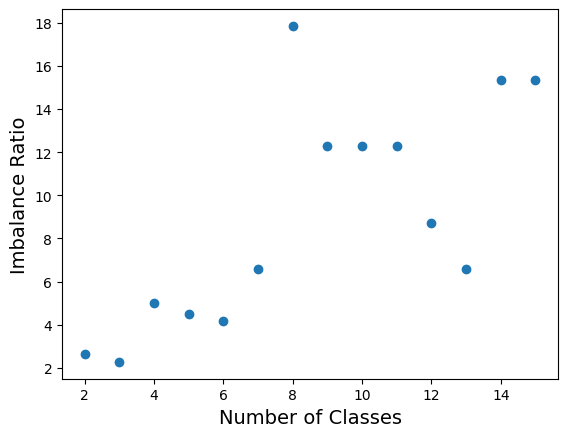

In [ ]:
# plot the results of the Jenks optimization based on IR (imbalance ratio)
fig = plt.figure()
plt.plot([t[0] for t in ir],
         [t[1] for t in ir],'o')
ax = plt.gca()
ax.set_xlabel('Number of Classes',fontsize=14)
ax.set_ylabel('Imbalance Ratio',fontsize=14)

Text(0.5, 0, 'Reservoir Temperature (°C)')

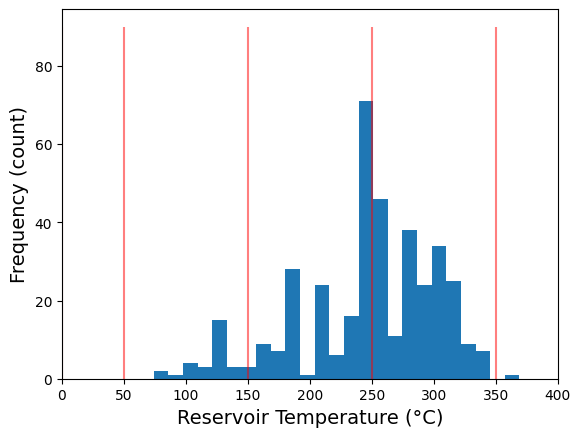

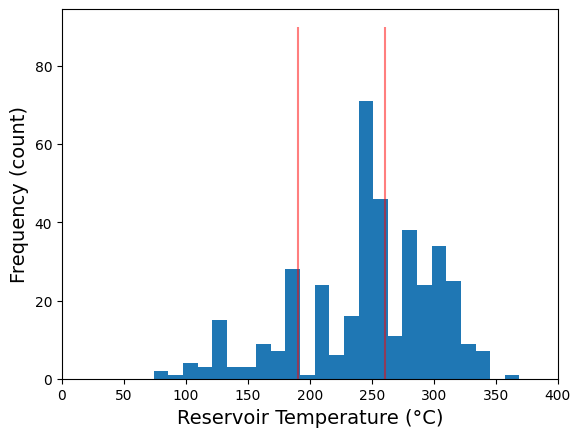

In [ ]:
# illustrate the split from brute force vs. using Jenks
plt.figure()
gdf['Reservoir temperature (°C)'].hist(density=False,bins=25,grid=False)
plt.xlim(0,400)
plt.vlines([0,50,150,250,350],0,90,colors='red',linestyles='solid',alpha=0.5)
plt.gca().set_ylabel('Frequency (count)',fontsize=14)
plt.gca().set_xlabel('Reservoir Temperature (°C)',fontsize=14)

plt.figure()
gdf['Reservoir temperature (°C)'].hist(density=False,bins=25,grid=False)
plt.xlim(0,400)
plt.vlines([190.0,260.385],0,90,colors='red',linestyles='solid',alpha=0.5)
plt.gca().set_ylabel('Frequency (count)',fontsize=14)
plt.gca().set_xlabel('Reservoir Temperature (°C)',fontsize=14)

### repeat optimized binning for other variables

In [ ]:
# use power plant lat/lon values from Rystad
gdf['Latitude'] = gdf['RystadLatitude']
gdf['Longitude'] = gdf['RystadLongitude']

In [ ]:
# look for best binning scheme for Latitude
ir = []
for i in range(10,37):
  breaks = jenkspy.jenks_breaks(gdf['Latitude'],n_classes=i)
  class_dist = pd.cut(gdf['Latitude'],bins=breaks,right=True,ordered=True,include_lowest=True).value_counts()
  majorclass,minorclass = class_dist.max(),class_dist.min()
  ir.append((i,majorclass/minorclass))
print(ir)

# Find the tuple with the minimum second value
min_tuple = min(ir, key=lambda x: x[1])
print('optimal result: ', min_tuple)

[(10, 15.6), (11, 15.6), (12, 15.6), (13, 15.6), (14, 10.4), (15, 10.4), (16, 17.333333333333332), (17, 17.333333333333332), (18, 16.666666666666668), (19, 16.666666666666668), (20, 16.666666666666668), (21, 16.666666666666668), (22, 50.0), (23, 50.0), (24, 50.0), (25, 50.0), (26, 50.0), (27, 50.0), (28, 50.0), (29, 50.0), (30, 50.0), (31, 48.0), (32, 48.0), (33, 48.0), (34, 48.0), (35, 48.0), (36, 48.0)]
optimal result:  (14, 10.4)


In [ ]:
breaks = jenkspy.jenks_breaks(gdf['Latitude'],n_classes=min_tuple[0])
print(breaks)
gdf['LatitudeBinned'] = pd.cut(gdf['Latitude'],bins=breaks,right=True,ordered=True,include_lowest=True)
gdf['LatitudeBinned']

[-38.6263, -35.4031, -5.30882, -0.863367, 3.227225, 11.16171, 16.12754, 21.185675, 31.19073, 33.28365, 37.95053, 40.9951, 44.0227, 52.53842, 65.7035]


,LatitudeBinned
0,"(11.162, 16.128]"
1,"(11.162, 16.128]"
2,"(11.162, 16.128]"
3,"(37.951, 40.995]"
4,"(33.284, 37.951]"
...,...
383,"(21.186, 31.191]"
384,"(21.186, 31.191]"
385,"(21.186, 31.191]"
386,"(21.186, 31.191]"


In [ ]:
# look for best binning scheme for Longitude
ir = []
for i in range(5,37):
  breaks = jenkspy.jenks_breaks(gdf['Longitude'],n_classes=i)
  class_dist = pd.cut(gdf['Longitude'],bins=breaks,right=True,
                      ordered=True,include_lowest=True,duplicates='drop').value_counts()
  majorclass,minorclass = class_dist.max(),class_dist.min()
  ir.append((i,majorclass/minorclass))
print(ir)

# Find the tuple with the minimum second value
min_tuple = min(ir, key=lambda x: x[1])
print('optimal result: ', min_tuple)

[(5, 3.638888888888889), (6, 3.088235294117647), (7, 2.5294117647058822), (8, 3.185185185185185), (9, 20.5), (10, 20.5), (11, 20.5), (12, 20.5), (13, 41.0), (14, 41.0), (15, 23.5), (16, 23.5), (17, 23.5), (18, 23.5), (19, 23.5), (20, 23.5), (21, 23.5), (22, 23.5), (23, 23.5), (24, 23.5), (25, 23.5), (26, 23.5), (27, 23.5), (28, 23.5), (29, 23.5), (30, 23.5), (31, 47.0), (32, 47.0), (33, 47.0), (34, 47.0), (35, 47.0), (36, 47.0)]
optimal result:  (7, 2.5294117647058822)


In [ ]:
breaks = jenkspy.jenks_breaks(gdf['Longitude'],n_classes=min_tuple[0])
print(breaks)
gdf['LongitudeBinned'] = pd.cut(gdf['Longitude'],bins=breaks,right=True,ordered=True,include_lowest=True)
gdf['LongitudeBinned']

[-154.889, -112.558841, -61.7688, -16.77366, 36.35103, 109.8978, 140.9368, 176.725]


,LongitudeBinned
0,"(-112.559, -61.769]"
1,"(-112.559, -61.769]"
2,"(-112.559, -61.769]"
3,"(-154.89000000000001, -112.559]"
4,"(-61.769, -16.774]"
...,...
383,"(36.351, 109.898]"
384,"(36.351, 109.898]"
385,"(36.351, 109.898]"
386,"(36.351, 109.898]"


In [ ]:
# fix missing commission years
gdf.loc[:,'FirstCommissionYear'] = [s if c == 9999 else c for s,c in zip(gdf['EstFirstYear'],gdf['FirstCommissionYear'])]

In [ ]:
# look for best binning scheme for Start Year
ir = []
for i in range(2,11):
  breaks = jenkspy.jenks_breaks(gdf['FirstCommissionYear'],n_classes=i)
  class_dist = pd.cut(gdf['FirstCommissionYear'],bins=breaks,right=True,duplicates='drop',ordered=True,include_lowest=True).value_counts()
  # print(class_dist)
  majorclass,minorclass = class_dist.max(),class_dist.min()
  ir.append((i,majorclass/minorclass))
print(ir)

# Find the tuple with the minimum second value
min_tuple = min(ir, key=lambda x: x[1])
print('optimal result: ', min_tuple)

[(2, 1.3515151515151516), (3, 2.4805194805194803), (4, 10.823529411764707), (5, 8.941176470588236), (6, 8.941176470588236), (7, 6.588235294117647), (8, 6.588235294117647), (9, 2.606060606060606), (10, 2.6666666666666665)]
optimal result:  (2, 1.3515151515151516)


In [ ]:
breaks = jenkspy.jenks_breaks(gdf['FirstCommissionYear'],n_classes=min_tuple[0])
print(breaks)
gdf['StartYearBinned'] = pd.cut(gdf['FirstCommissionYear'],bins=breaks,right=True,ordered=True,include_lowest=True, duplicates='drop')
gdf['StartYearBinned']

[1958.0, 1990.36893203883, 2018.0]


,StartYearBinned
0,"(1957.999, 1990.369]"
1,"(1957.999, 1990.369]"
2,"(1957.999, 1990.369]"
3,"(1957.999, 1990.369]"
4,"(1990.369, 2018.0]"
...,...
383,"(1957.999, 1990.369]"
384,"(1957.999, 1990.369]"
385,"(1957.999, 1990.369]"
386,"(1957.999, 1990.369]"


# add columns from ECM-1 model

In [ ]:
ecm_orig

,Numb,Lon,Lat,Hcc,Sed,Hc,Type,DLy1,DLy2,DLy3,...,VP3,VS1,VS2,VS3,VPN,VSN,RHO1,RHO2,RHO3,RHON
0,1,-179.5,89.5,6.4459,2.3303,8.7762,SOCE,4.4574,6.5846,8.7762,...,6.739467,3.217479,3.441446,3.807608,8.028349,4.467863,2.654495,2.736552,2.895387,3.301104
1,2,-178.5,89.5,6.3511,2.3344,8.6854,SOCE,4.4302,6.5261,8.6854,...,6.739467,3.217479,3.441446,3.807608,8.028349,4.467863,2.654495,2.736552,2.895387,3.301104
2,3,-177.5,89.5,6.2512,2.3398,8.5910,SOCE,4.4027,6.4656,8.5910,...,6.739467,3.217479,3.441446,3.807608,8.028349,4.467863,2.654495,2.736552,2.895387,3.301104
3,4,-176.5,89.5,6.1516,2.3463,8.4980,SOCE,4.3764,6.4064,8.4980,...,6.739467,3.217479,3.441446,3.807608,8.028349,4.467863,2.654495,2.736552,2.895387,3.301104
4,5,-175.5,89.5,6.0578,2.3520,8.4098,SOCE,4.3510,6.3501,8.4098,...,6.739467,3.217479,3.441446,3.807608,8.028349,4.467863,2.654495,2.736552,2.895387,3.301104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64795,64796,175.5,-89.5,39.0010,0.0000,39.0010,PLAT,12.8703,25.7406,39.0010,...,6.909733,3.572958,3.766211,3.959193,8.127480,4.538286,2.752636,2.842270,2.942304,3.336778
64796,64797,176.5,-89.5,39.0014,0.0000,39.0014,PLAT,12.8705,25.7409,39.0014,...,6.909733,3.572958,3.766211,3.959193,8.127480,4.538286,2.752636,2.842270,2.942304,3.336778
64797,64798,177.5,-89.5,39.0018,0.0000,39.0018,PLAT,12.8706,25.7412,39.0018,...,6.909733,3.572958,3.766211,3.959193,8.127480,4.538286,2.752636,2.842270,2.942304,3.336778
64798,64799,178.5,-89.5,39.0023,0.0000,39.0023,PLAT,12.8708,25.7415,39.0023,...,6.909733,3.572958,3.766211,3.959193,8.127480,4.538286,2.752636,2.842270,2.942304,3.336778


In [ ]:
# Create the interpolating function
latitudes  = ecm_orig['Lat'].unique()
longitudes = ecm_orig['Lon'].unique()

In [ ]:
# save off crystalline crustal thickness
values = ecm_orig['Hcc'].values.reshape(len(latitudes), len(longitudes))
interp_hcc = RegularGridInterpolator((latitudes, longitudes), values, method='linear')
gdf.loc[:,'CCrustThick'] = [interp_hcc([lat,lon])[0] for lat,lon in zip(gdf.Latitude,gdf.Longitude)]

<Axes: >

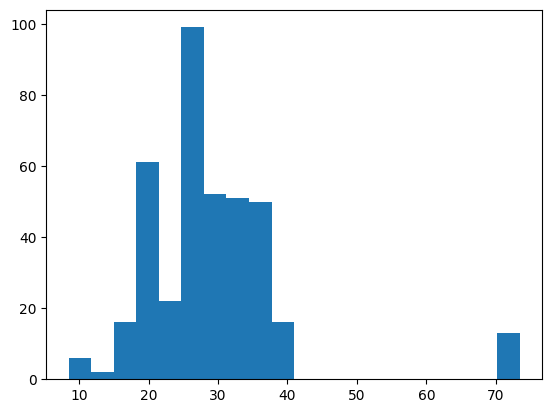

In [ ]:
gdf.CCrustThick.hist(density=False,bins=20,grid=False)

<Axes: >

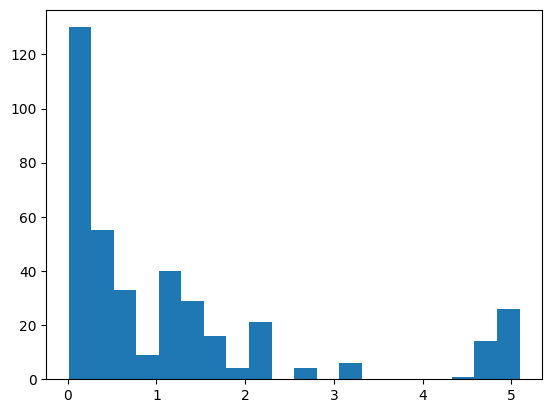

In [ ]:
# save off sediment thickness
values = ecm_orig['Sed'].values.reshape(len(latitudes), len(longitudes))
interp_sed = RegularGridInterpolator((latitudes, longitudes), values, method='linear')
gdf.loc[:,'SedThick'] = [interp_sed([lat,lon])[0] for lat,lon in zip(gdf.Latitude,gdf.Longitude)]
gdf.SedThick.hist(density=False,bins=20,grid=False)

In [ ]:
# capture all velocity and density profiles from the earth model
for var in ['VP1','VP2','VP3', 'VS1', 'VS2','VS3', 'VPN', 'VSN', 'RHO1', 'RHO2', 'RHO3', 'RHON']:
  values = ecm_orig[var].values.reshape(len(latitudes), len(longitudes))
  interp_var = RegularGridInterpolator((latitudes, longitudes), values, method='linear')
  gdf.loc[:,var] = [interp_var([lat,lon])[0] for lat,lon in zip(gdf.Latitude,gdf.Longitude)]

<Axes: >

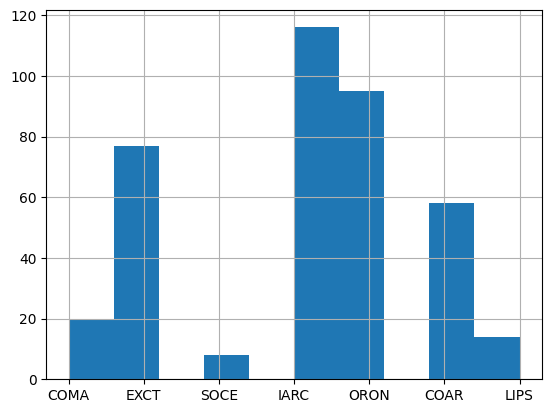

In [ ]:
# add crust type
values = ecm_orig['Type'].values.reshape(len(latitudes), len(longitudes))
def lookupstring(lat,lon) -> str:
  distances = np.sqrt((ecm_orig['Lat'] - lat)**2 +
                      (ecm_orig['Lon'] - lon)**2)

  closest_idx = distances.idxmin()
  return ecm_orig.loc[closest_idx,'Type']
gdf.loc[:,'CrustType'] = [lookupstring(lat,lon) for lat,lon in zip(gdf.Latitude,gdf.Longitude)]
gdf.CrustType.hist()

In [ ]:
# look for nonsense assignments, like Continental Margin
gdf[gdf.CrustType == 'COMA']

,Name,WS_Temp,WS_PowerDensity,WS_TectonicRegime,Country_x,PowerPlant,Latitude,Longitude,Elevation,MatchName_x,...,VS1,VS2,VS3,VPN,VSN,RHO1,RHO2,RHO3,RHON,CrustType
0,Ahuachapan,250.0,14.420000,Arcs,Central_America,Ahuachapan,13.920400,-89.81740,798.0,Ahuachapan,...,3.442917,3.696258,3.798172,7.983957,4.509156,2.716551,2.840787,2.896390,3.285380,COMA
1,Ahuachapan,250.0,14.420000,Arcs,Central_America,Ahuachapan,13.920500,-89.81730,798.0,Ahuachapan,...,3.442917,3.696260,3.798174,7.983948,4.509162,2.716552,2.840790,2.896397,3.285376,COMA
2,Ahuachapan,250.0,14.420000,Arcs,Central_America,Ahuachapan,13.920600,-89.81720,798.0,Ahuachapan,...,3.442917,3.696262,3.798177,7.983939,4.509167,2.716554,2.840792,2.896403,3.285373,COMA
93,Lahendong,280.0,18.395062,Arcs,Indonesia_PapuaNG,Lahendong,1.254760,124.82260,877.0,Lahendong,...,3.429923,3.674367,3.784800,8.002333,4.454687,2.713885,2.836155,2.886241,3.291903,COMA
94,Lahendong,280.0,18.395062,Arcs,Indonesia_PapuaNG,Lahendong,1.254860,124.82270,877.0,Lahendong,...,3.429931,3.674374,3.784802,8.002345,4.454704,2.713883,2.836151,2.886231,3.291907,COMA
95,Lahendong,280.0,18.395062,Arcs,Indonesia_PapuaNG,Lahendong,1.271275,124.83560,877.0,Lahendong,...,3.431114,3.675395,3.785082,8.004112,4.457314,2.713541,2.835554,2.884760,3.292530,COMA
96,Lahendong,280.0,18.395062,Arcs,Indonesia_PapuaNG,Lahendong,1.271375,124.83570,877.0,Lahendong,...,3.431122,3.675402,3.785083,8.004123,4.457330,2.713538,2.835551,2.884751,3.292534,COMA
97,Lahendong,280.0,18.395062,Arcs,Indonesia_PapuaNG,Lahendong,1.273236,124.83520,877.0,Lahendong,...,3.431216,3.675483,3.785106,8.004264,4.457539,2.713511,2.835503,2.884634,3.292584,COMA
98,Lahendong,280.0,18.395062,Arcs,Indonesia_PapuaNG,Lahendong,1.270222,124.83580,877.0,Lahendong,...,3.431059,3.675348,3.785069,8.004030,4.457193,2.713557,2.835582,2.884829,3.292501,COMA
129,Las Pailas,245.0,9.506173,Arcs,Central_America,Las Pailas,10.757480,-85.34660,642.0,Las Pailas,...,3.441750,3.692850,3.797749,7.991690,4.499692,2.715602,2.837268,2.891838,3.288115,COMA


In [ ]:
# fix designations
gdf.set_index('Name',inplace=True)

# PapuaNG is island arc
gdf.loc['Mataloko','CrustType']   = 'IARC'
gdf.loc['Lihir','CrustType']      = 'IARC'
gdf.loc['Lahendong','CrustType']  = 'IARC'

# Central American volcanism is Continental Arc
gdf.loc['Las Pailas','CrustType'] = 'CARC'
gdf.loc['Miravalles','CrustType'] = 'CARC'
gdf.loc['Ahuachapan','CrustType'] = 'CARC'

gdf.reset_index(drop=False,inplace=True)

# look for nonsense assignments, like Continental Margin
gdf[gdf.CrustType == 'COMA']

,Name,WS_Temp,WS_PowerDensity,WS_TectonicRegime,Country_x,PowerPlant,Latitude,Longitude,Elevation,MatchName_x,...,VS1,VS2,VS3,VPN,VSN,RHO1,RHO2,RHO3,RHON,CrustType


### Add Crustal Thickness Gradient from horizontal gradient applied to Hcc (crystalline crust)

In [ ]:
gct_orig

,Longitude,Latitude,Gradient
0,-179.50,-89.5,1.807161
1,-179.25,-89.5,1.961738
2,-179.00,-89.5,1.967465
3,-178.75,-89.5,1.948373
4,-178.50,-89.5,1.903459
...,...,...,...
1030324,178.50,89.5,1.028454
1030325,178.75,89.5,1.103621
1030326,179.00,89.5,1.221283
1030327,179.25,89.5,1.390467


<Axes: >

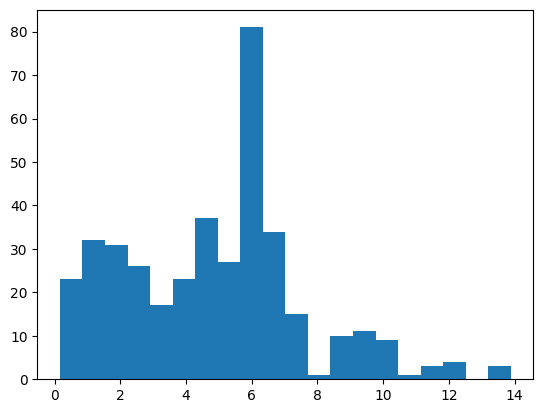

In [ ]:
latitudes  = gct_orig['Latitude'].unique()
longitudes = gct_orig['Longitude'].unique()
values = gct_orig['Gradient'].values.reshape(len(latitudes), len(longitudes))

interp_gct = RegularGridInterpolator((latitudes, longitudes), values, method='linear')
gdf.loc[:,'GradHcc'] = [interp_gct([lat,lon])[0] for lat,lon in zip(gdf.Latitude,gdf.Longitude)]
gdf.GradHcc.hist(density=False,bins=20,grid=False)

## Add Heat Flow from Lucazeau, 2019 Model

<Axes: >

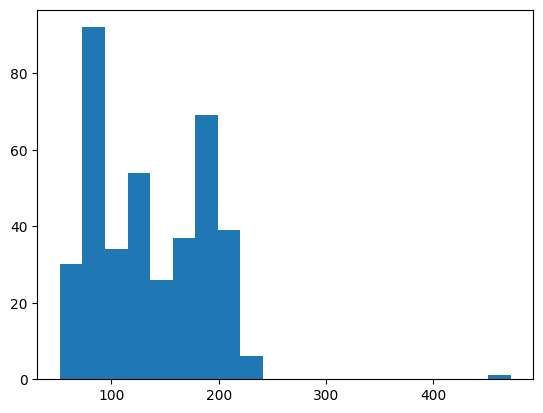

In [ ]:
hf_orig.columns = ['Longitude','Latitude','HF_pred','sHF_pred','HF_obs']

latitudes  = hf_orig['Latitude'].unique()
longitudes = hf_orig['Longitude'].unique()
values = hf_orig['HF_pred'].values.reshape(len(latitudes), len(longitudes))

interp_hf = RegularGridInterpolator((latitudes, longitudes), values, method='linear')
gdf.loc[:,'HeatFlow'] = [interp_hf([lat,lon])[0] for lat,lon in zip(gdf.Latitude,gdf.Longitude)]
gdf.HeatFlow.hist(density=False,bins=20,grid=False)

In [ ]:
gdf.columns

Index(['Name', 'WS_Temp', 'WS_PowerDensity', 'WS_TectonicRegime', 'Country_x',
       'PowerPlant', 'Latitude', 'Longitude', 'Elevation', 'MatchName_x',
       'CountryShort', 'CountryLong', 'GPPDBName', 'NameplateCapacity',
       'GPPDBLatitude', 'GPPDBLongitude', 'FirstCommissionYear', 'Owner',
       'EstGenerationPerYear', 'Country_y', 'State', 'Project', 'Asset',
       'TectonicRegime', 'MatchName_y', 'RystadLatitude', 'RystadLongitude',
       'Asset purpose', 'Technology', 'Subsurface system', 'Temperature',
       'Reservoir temperature (°C)', 'Startup year',
       'Installed capacity (MWe)', 'Production wells', 'Total wells',
       'Drilling length group (meters)', 'MW per well', 'PowerPerWell',
       'EstFirstYear', 'WorldClim_AvgTemp', 'WorldClim_MinTemp',
       'WorldClim_MaxTemp', 'WorldClim_AvgPrec', 'WorldClim_TempRange',
       'PDTemp_Edited', 'Geography', 'ResTempBinned', 'LatitudeBinned',
       'LongitudeBinned', 'StartYearBinned', 'CCrustThick', 'SedThick', '

In [ ]:
# discritize earth model variables
# capture all velocity and density profiles from the earth model
for var in ['VP1','VP2','VP3','VS1','VS2','VS3','VPN','VSN','RHO1','RHO2','RHO3','RHON','HeatFlow']:
  print(var)
  # look for best binning scheme for Start Year
  ir = []
  for i in range(3,10):
    breaks = jenkspy.jenks_breaks(gdf[var],n_classes=i)
    class_dist = pd.cut(gdf[var],bins=breaks,right=True,duplicates='drop',ordered=True,include_lowest=True).value_counts()
    majorclass,minorclass = class_dist.max(),class_dist.min()
    ir.append((i,majorclass/minorclass))

  print(ir)
  # Find the tuple with the minimum second value
  min_tuple = min(ir, key=lambda x: x[1])
  print('optimal result: ', min_tuple)

  breaks = jenkspy.jenks_breaks(gdf[var],n_classes=min_tuple[0])
  print(breaks)
  gdf[f'{var}Binned'] = pd.cut(gdf[var],bins=breaks,right=True,ordered=True,include_lowest=True,duplicates='drop')

VP1
[(3, 21.875), (4, 17.133333333333333), (5, 16.066666666666666), (6, 11.6), (7, 58.0), (8, 55.666666666666664), (9, 36.333333333333336)]
optimal result:  (6, 11.6)
[5.671926941, 5.694938089, 5.920672132263659, 6.000988079973887, 6.031085347051284, 6.057485908238828, 6.080603692]
VP2
[(3, 8.0), (4, 6.8), (5, 5.454545454545454), (6, 15.0), (7, 13.625), (8, 13.625), (9, 12.125)]
optimal result:  (5, 5.454545454545454)
[6.091359728999999, 6.264648117533795, 6.412697305208201, 6.499593265580801, 6.586622632267384, 6.649665988000001]
VP3
[(3, 2.1739130434782608), (4, 3.7058823529411766), (5, 2.690909090909091), (6, 12.454545454545455), (7, 12.454545454545455), (8, 12.363636363636363), (9, 12.363636363636363)]
optimal result:  (3, 2.1739130434782608)
[6.686239200847057, 6.820414574755112, 6.935105825403499, 7.018598114000001]
VS1
[(3, 7.264705882352941), (4, 5.6), (5, 9.764705882352942), (6, 9.705882352941176), (7, 5.529411764705882), (8, 11.75), (9, 11.75)]
optimal result:  (7, 5.52941176

### create label encodings for values

In [ ]:
# down-select to only the columns to test
keepcols = ['Name','CountryLong','Geography','WS_Temp','PDTemp_Edited',
            'Reservoir temperature (°C)','ResTempBinned','WS_PowerDensity','WS_TectonicRegime',
            'Latitude','Longitude','LatitudeBinned','LongitudeBinned',
            'Elevation','Startup year','StartYearBinned','Installed capacity (MWe)',
            'Production wells','Total wells','Technology','Drilling length group (meters)',
            'PowerPerWell','WorldClim_AvgTemp','WorldClim_MinTemp','WorldClim_MaxTemp',
            'WorldClim_TempRange','WorldClim_AvgPrec','CCrustThick','SedThick',
            'VP1','VP2','VP3','VS1',
            'VS2','VS3','VPN','VSN',
            'RHO1','RHO2','RHO3','RHON',
            'CrustType','GradHcc','HeatFlow','VP1Binned',
            'VP2Binned','VP3Binned','VS1Binned','VS2Binned',
            'VS3Binned','VPNBinned','VSNBinned','RHO1Binned',
            'RHO2Binned','RHO3Binned','RHONBinned','HeatFlowBinned']
colnames = ['Name','Country','Region','PDTemp','PDTemp_Edited',
            'ResTemp','ResTempBinned','PDPowerDensity','TectonicSetting',
            'LatitudeDegree','LongitudeDegree','LatitudeBinned','LongitudeBinned',
            'Elevation','StartYear','StartYearBinned','NameplateCapacity',
            'ProdWellCount','TotWellCount','PlantType','DrillLengthBinned',
            'PowerPerWell','AvgAmbientTemp','MinAmbientTemp','MaxAmbientTemp',
            'AmbientTempRange','AvgPrecipitation','CCrustThick','SedThick',
            'VP1','VP2','VP3','VS1',
            'VS2','VS3','VPN','VSN',
            'RHO1','RHO2','RHO3','RHON',
            'CrustType','GradCCrustThick','HeatFlow','VP1Binned',
            'VP2Binned','VP3Binned','VS1Binned','VS2Binned',
            'VS3Binned','VPNBinned','VSNBinned','RHO1Binned',
            'RHO2Binned','RHO3Binned','RHONBinned','HeatFlowBinned']
gdf = gdf[keepcols]
gdf.columns = colnames

In [ ]:
# start with ordinal encoding any binned variables that are ordered
numcols = gdf.select_dtypes(include=['int64', 'float64']).columns
ordcols = [c for c in gdf.select_dtypes(include=['category','object']).columns if 'Binned' in c ]
labcols = [c for c in gdf.select_dtypes(include=['category','object']).columns if 'Binned' not in c]

print(numcols, ordcols, labcols)

Index(['PDTemp', 'PDTemp_Edited', 'ResTemp', 'PDPowerDensity',
       'LatitudeDegree', 'LongitudeDegree', 'Elevation', 'StartYear',
       'NameplateCapacity', 'ProdWellCount', 'TotWellCount', 'PowerPerWell',
       'AvgAmbientTemp', 'MinAmbientTemp', 'MaxAmbientTemp',
       'AmbientTempRange', 'AvgPrecipitation', 'CCrustThick', 'SedThick',
       'VP1', 'VP2', 'VP3', 'VS1', 'VS2', 'VS3', 'VPN', 'VSN', 'RHO1', 'RHO2',
       'RHO3', 'RHON', 'GradCCrustThick', 'HeatFlow'],
      dtype='object') ['ResTempBinned', 'LatitudeBinned', 'LongitudeBinned', 'StartYearBinned', 'DrillLengthBinned', 'VP1Binned', 'VP2Binned', 'VP3Binned', 'VS1Binned', 'VS2Binned', 'VS3Binned', 'VPNBinned', 'VSNBinned', 'RHO1Binned', 'RHO2Binned', 'RHO3Binned', 'RHONBinned', 'HeatFlowBinned'] ['Name', 'Country', 'Region', 'TectonicSetting', 'PlantType', 'CrustType']


In [ ]:
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

# encode ordinal values, one-hot encode label values
gdfenc = gdf.copy(deep=True)

# keep track of any encodings
encoders = {}

# encode ordinal values first
for c in ordcols:
  print(c)
  oe = OrdinalEncoder()
  gdfenc[c] = oe.fit_transform(gdfenc[[c]])
  encoders[c] = oe

# now take care of labelled items (except Name)
for c in labcols:
  if (c == 'Name') | (c == 'Country'):
    continue

  # replace with one hot encoding
  onehot = pd.get_dummies(gdfenc[c])
  gdfenc = pd.concat([gdfenc.drop([c],axis=1),onehot],axis=1)

# reset column lists
boolcols = gdfenc.select_dtypes(include=['bool']).columns
numcols  = gdfenc.select_dtypes(include=['int64', 'float64']).columns
labcols  = gdfenc.select_dtypes(include=['category', 'object']).columns
print(boolcols)
print(numcols)
print(labcols)

ResTempBinned
LatitudeBinned
LongitudeBinned
StartYearBinned
DrillLengthBinned
VP1Binned
VP2Binned
VP3Binned
VS1Binned
VS2Binned
VS3Binned
VPNBinned
VSNBinned
RHO1Binned
RHO2Binned
RHO3Binned
RHONBinned
HeatFlowBinned
Index(['Africa', 'Central America', 'East Asia', 'Eurasia', 'Europe',
       'North America', 'North Asia', 'Oceania', 'Southeast Asia', 'Arcs',
       'Fault-Based', 'Other', 'Rifts', 'Binary', 'Dry steam', 'Flash',
       'Hybrid', 'CARC', 'COAR', 'EXCT', 'IARC', 'LIPS', 'ORON', 'SOCE'],
      dtype='object')
Index(['PDTemp', 'PDTemp_Edited', 'ResTemp', 'ResTempBinned', 'PDPowerDensity',
       'LatitudeDegree', 'LongitudeDegree', 'LatitudeBinned',
       'LongitudeBinned', 'Elevation', 'StartYear', 'StartYearBinned',
       'NameplateCapacity', 'ProdWellCount', 'TotWellCount',
       'DrillLengthBinned', 'PowerPerWell', 'AvgAmbientTemp', 'MinAmbientTemp',
       'MaxAmbientTemp', 'AmbientTempRange', 'AvgPrecipitation', 'CCrustThick',
       'SedThick', 'VP1', 'VP2', 'V

In [ ]:
# list out encodings
for e in encoders.keys():
  print(e)
  if isinstance(encoders[e], OrdinalEncoder):
    print(encoders[e].categories_)
  else:
    print(encoders[e].classes_)

ResTempBinned
[array([Interval(73.999, 200.0, closed='right'),
       Interval(200.0, 270.0, closed='right'),
       Interval(270.0, 369.0, closed='right')], dtype=object)]
LatitudeBinned
[array([Interval(-38.626999999999995, -35.403, closed='right'),
       Interval(-35.403, -5.309, closed='right'),
       Interval(-5.309, -0.863, closed='right'),
       Interval(-0.863, 3.227, closed='right'),
       Interval(3.227, 11.162, closed='right'),
       Interval(11.162, 16.128, closed='right'),
       Interval(16.128, 21.186, closed='right'),
       Interval(21.186, 31.191, closed='right'),
       Interval(31.191, 33.284, closed='right'),
       Interval(33.284, 37.951, closed='right'),
       Interval(37.951, 40.995, closed='right'),
       Interval(40.995, 44.023, closed='right'),
       Interval(44.023, 52.538, closed='right'),
       Interval(52.538, 65.704, closed='right')], dtype=object)]
LongitudeBinned
[array([Interval(-154.89000000000001, -112.559, closed='right'),
       Interval

### save out all data engineering work

In [ ]:
# save off both an excel version and raw data one (to preserve categoricals)
gdf.to_excel(dirpath / 'Output' / 'gdf_complete_PLANTS.xlsx')

# save dataFrames and dictionary to a pickle file
with open(dirpath / 'Output' / 'gdf_complete_PLANTS.pkl', 'wb') as f:
    pkl.dump((gdf, gdfenc, encoders), f)

# # Load dataFrames and dictionary from a pickle file
# with open(dirpath / 'Output' / 'gdf_complete_PLANTS.pkl', 'rb') as f:
#     gdf, gdfenc, encoders = pkl.load(f)